In [1]:
import os
import sys
sys.path.append('../sdbm/code')
sys.path.append('../DeepView/deepview')
sys.path.append('../dbm_evaluation')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from map_evaluation import P_wrapper

2023-07-13 15:02:09.813157: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 15:02:09.840167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 15:02:10.270163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
# check GPU
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))


/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-13 15:02:13.821367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 5549 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# %matplotlib widget

In [11]:
X, y = make_blobs(n_samples=200, centers=6, n_features=10, random_state=0)
X = MinMaxScaler().fit_transform(X)
clf = LogisticRegression(random_state=0).fit(X, y)

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# ssnp = SSNP(bottleneck_activation='linear', verbose=0)
# ssnp.fit(X, y, )

projecter = P_wrapper(deepview=1, ssnp=0, NNinv_Torch=0)
projecter.fit(X, y, clf)

100%|██████████| 200/200 [00:00<00:00, 1516.64it/s]


updating matrices
(0,) (200, 200)
discr 0.0003750324249267578
(0,) (200, 200)
fitting mapper
transforming
fitting inverse
done
fitting time:  3.1260435581207275


3.1260435581207275

100%|██████████| 200/200 [00:00<00:00, 713.16it/s]


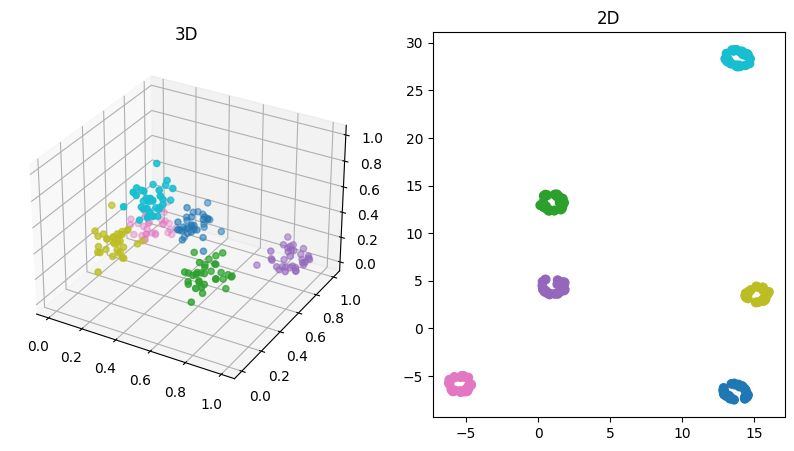

In [12]:
X_2d = projecter.transform(X)
# plot 3d, and 2d
fig0 = plt.figure(figsize=(10, 5))
ax0 = fig0.add_subplot(121, projection='3d')
ax0.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10')
ax0.set_title('3D')
ax = fig0.add_subplot(122)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10')
ax.set_title('2D')
plt.show()

In [13]:
class ID_finder_T:
    def __init__(self):
        self.LID_map = None
        self.DM = None
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

    def get_LID(self, X_2d, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
        self.DM = DM

        pixel_w = (X_2d[:, 0].max() - X_2d[:, 0].min()) / (grid-1)
        pixel_h = (X_2d[:, 1].max() - X_2d[:, 1].min()) / (grid-1)

        xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), grid),
                            np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), grid))
        XY = np.c_[xx.ravel(), yy.ravel()]

        LID_map = np.zeros(XY.shape[0])
        data_shape = DM.inverse_transform(np.zeros((5 ,2)))
        # print(data_shape)
        LID_eval = T.zeros((XY.shape[0], data_shape.shape[1])).to(self.device)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y , cmap='tab10')
        ax.set_title('2D _debug')

        for i, pix in tqdm(enumerate(XY)):
            ax.scatter(pix[0], pix[1], c='r', marker='+')
            subset = self.get_subset(pix, pixel_w, pixel_h, sample_size)
            ax.scatter(subset[:, 0], subset[:, 1], c='g', marker='x')
            local_cov = self.compute_cov(subset)
            LID_eval[i] = local_cov
            # value = self.process_results(local_cov, mode)
            # LID_map[pix] = value
        LID_map = self.process_results(LID_eval, mode)
        self.LID_map = LID_map.reshape(grid, grid).to('cpu').numpy()
        self.LID_eval = LID_eval.to('cpu').numpy()

    def get_subset(self, center, w, h, n_samples):
        # def sample_uniform_2d(center, size, n_samples):
        """
        Generate `n_samples` uniformly distributed within a square of `size` around `center`.

        Parameters:
        center (tuple): The center of the square (x, y).
        size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
        n_samples (int): The number of samples to generate.

        Returns:
        numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
        """
        x, y = center
        lower = [x - w/2, y - h/2]
        upper = [x + w/2, y + h/2]

        samples = np.random.uniform(lower, upper, (n_samples, 2))
        return samples

    def compute_cov(self, subset):
        # to cuda, then compute cov
        subset = self.DM.inverse_transform(subset)
        ax0.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c='g', marker='x', s=10)
        subset = T.tensor(subset, dtype=T.float32, device=self.device)
        cov = T.cov(subset.T)
        # comput eigenvalues
        eigvals, eig_vec = LA.eigh(cov)
        # order the eigenvalues
        # eigvals = T.sort(eigvals, descending=True)
        return eigvals

    def process_results(self, LID_eval, mode='dim'):
        ## sort the eigenvalues, 
        LID_eval, ind = T.sort(LID_eval, descending=True)
        # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
        ### LID_eval: (n_samples, n_features)
        eval_sum = T.sum(LID_eval, dim=1)
        LID_eval = LID_eval / eval_sum[:, None]

        if mode == 'dim':
            # how many dimensions are needed to explain 95% of the variance    
            cumsum = T.cumsum(LID_eval, dim=1)
            # cumsum = (cumsum > 0.95).float()  # convert bool tensor to float tensor
            # LID_eval = (cumsum * T.arange(1, cumsum.shape[1]+1).to(cumsum.device)).argmax(dim=1) + 1
            # calculate the number of dimensions needed to explain 95% of the variance
            LID_eval = (cumsum < 0.95).sum(dim=1) + 1
            

        elif mode == 'percent':
            LID_eval = T.sum(LID_eval[:, :2], dim=1)
        else:
            raise ValueError('mode should be either dim or percent')
        return LID_eval
       
            

    def plot_LID(self, X_2d, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=5):
        if DM != self.DM or self.LID_map is None:
            self.DM = DM
            # set the others to None
            self.get_LID(X_2d, grid=grid, DM=DM, mode=mode, sample_size=sample_size)

        map = np.flip(self.LID_map, axis=0)
        # map = self.LID_map
        if ax is None:
            plt.imshow(map, cmap=cmap)
            # cbar of this plot
            plt.colorbar()

        else:
            ax.imshow(map, cmap=cmap)
            # ax.colorbar()
            # cbar of this plot
            fig = ax.get_figure()
            cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            norm = mpl.colors.Normalize(vmin=map.min(), vmax=map.max())
            mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

In [14]:
class ID_finder:
    def __init__(self):
        self.LID_map = None
        self.DM = None
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

    def get_LID(self, X_2d, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
        self.DM = DM

        pixel_w = (X_2d[:, 0].max() - X_2d[:, 0].min()) / (grid-1)
        pixel_h = (X_2d[:, 1].max() - X_2d[:, 1].min()) / (grid-1)

        xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), grid),
                            np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), grid))
        XY = np.c_[xx.ravel(), yy.ravel()]

        LID_map = np.zeros(XY.shape[0])
        data_shape = DM.inverse_transform(np.zeros((5 ,2)))
        # print(data_shape)
        LID_eval = np.zeros((XY.shape[0], data_shape.shape[1]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y , cmap='tab10')
        ax.set_title('2D _debug')

        for i, pix in tqdm(enumerate(XY)):
            ax.scatter(pix[0], pix[1], c='r', marker='+')
            subset = self.get_subset(pix, pixel_w, pixel_h, sample_size)
            ax.scatter(subset[:, 0], subset[:, 1], c='g', marker='x')
            local_cov = self.compute_cov(subset)
            LID_eval[i] = local_cov
            # value = self.process_results(local_cov, mode)
            # LID_map[pix] = value
        print(LID_eval.shape)
        LID_map = self.process_results(LID_eval, mode)
        print(LID_map.shape)
        self.LID_map = LID_map.reshape(grid, grid)#.to('cpu').numpy()
        self.LID_eval = LID_eval#.to('cpu').numpy()

    def get_subset(self, center, w, h, n_samples):
        # def sample_uniform_2d(center, size, n_samples):
        """
        Generate `n_samples` uniformly distributed within a square of `size` around `center`.

        Parameters:
        center (tuple): The center of the square (x, y).
        size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
        n_samples (int): The number of samples to generate.

        Returns:
        numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
        """
        x, y = center
        lower = [x - w/2, y - h/2]
        upper = [x + w/2, y + h/2]

        samples = np.random.uniform(lower, upper, (n_samples, 2))
        return samples

    def compute_cov(self, subset):
        # to cuda, then compute cov
        subset = self.DM.inverse_transform(subset)
        ax0.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c='g', marker='x', s=10)
        # subset = T.tensor(subset, dtype=T.float32, device=self.device)
        cov = np.cov(subset.T)
        # comput eigenvalues
        eigvals = np.linalg.eigvalsh(cov)
        # order the eigenvalues
        # eigvals = T.sort(eigvals, descending=True)

        return eigvals

    def process_results(self, LID_eval, mode='dim'):
        ## sort the eigenvalues, 
        # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
        ### LID_eval: (n_samples, n_features)
                    # sort the eigenvalues
        LID_eval = np.sort(LID_eval, axis=1)
        # reverse the order
        LID_eval = LID_eval[:, ::-1]
        # cumsum
        # LID_eval = np.cumsum(LID_eval, axis=1)
        eval_sum = np.sum(LID_eval, keepdims=True, axis=1)

        # divide by the total sum
        LID_eval = LID_eval / eval_sum

        if mode == 'dim':
            # find the first value that is greater than 0.95
            acum = np.cumsum(LID_eval, axis=1)
            LID_val = np.argmax(acum > 0.98, axis=1) + 1
            
        elif mode == 'percent':
            # find the first value that is greater than 0.95
            LID_val = np.sum(LID_eval[:, 0:2], axis=1, keepdims=True)
        else:
            raise ValueError('mode must be either dim or percent')
        return LID_val



    def plot_LID(self, X_2d, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=10):
        if DM != self.DM or self.LID_map is None:
            self.DM = DM
            # set the others to None
            self.get_LID(X_2d, grid=grid, DM=DM, mode=mode, sample_size=sample_size)

        map = np.flip(self.LID_map, axis=0)
        # map = self.LID_map
        if ax is None:
            plt.imshow(map, cmap=cmap)
            # cbar of this plot
            plt.colorbar()

        else:
            ax.imshow(map, cmap=cmap)
            # ax.colorbar()
            # cbar of this plot
            fig = ax.get_figure()
            cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            norm = mpl.colors.Normalize(vmin=map.min(), vmax=map.max())
            mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

400it [01:24,  4.71it/s]


(400, 10)
(400, 1)


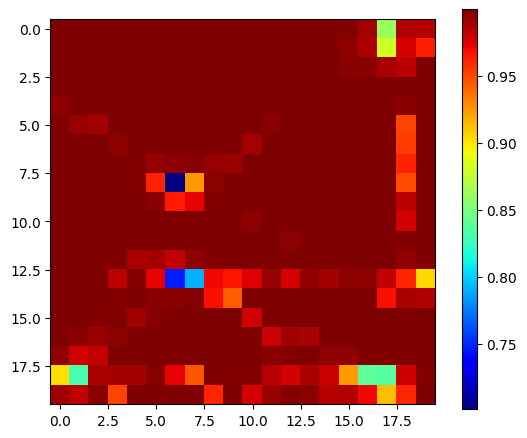

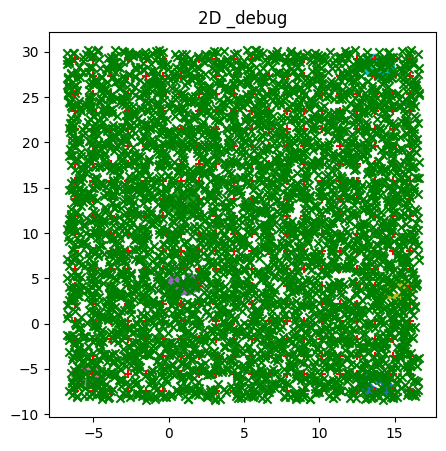

In [15]:
lid_finder = ID_finder()
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lid_finder.plot_LID(X_2d, DM=projecter, grid=20, mode='percent', ax=ax, sample_size=11)

2500it [07:03,  5.90it/s]


(2500, 10)
(2500,)


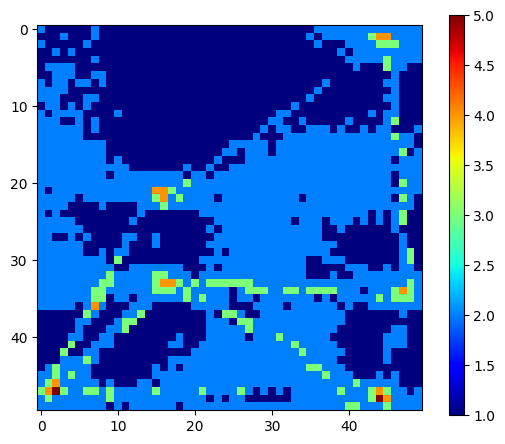

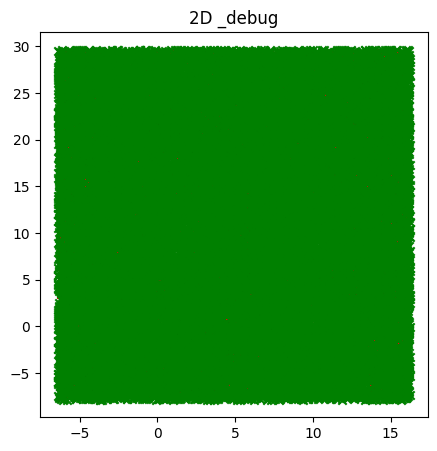

In [18]:
lid_finder = ID_finder()
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lid_finder.plot_LID(X_2d, DM=projecter, grid=50, mode='dim', ax=ax, sample_size=11)

In [ ]:
lid_finder.LID_eval.min() 

-2.2678715928838566e-18

0it [00:00, ?it/s]

400it [00:02, 145.59it/s]


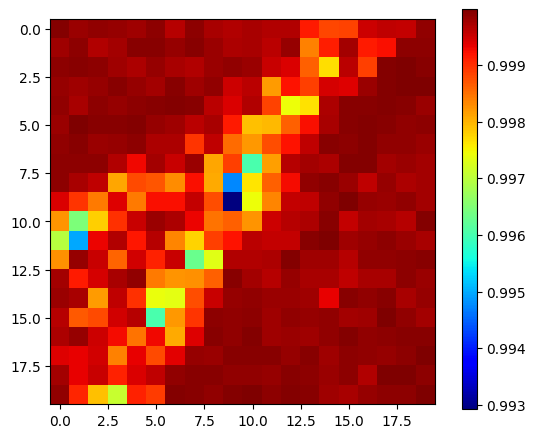

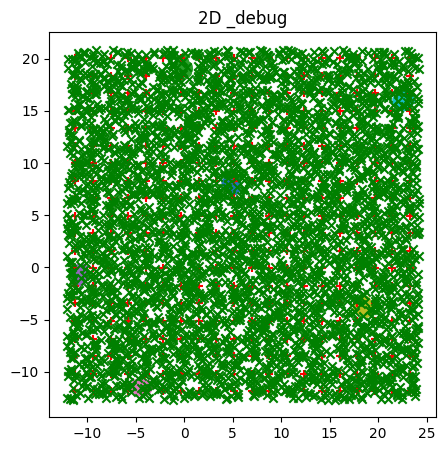

In [ ]:
lid_finder = ID_finder_T()
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lid_finder.plot_LID(X_2d, DM=projecter, grid=100, mode='percent', ax=ax, sample_size=10)


0it [00:00, ?it/s]

10000it [06:31, 25.52it/s]


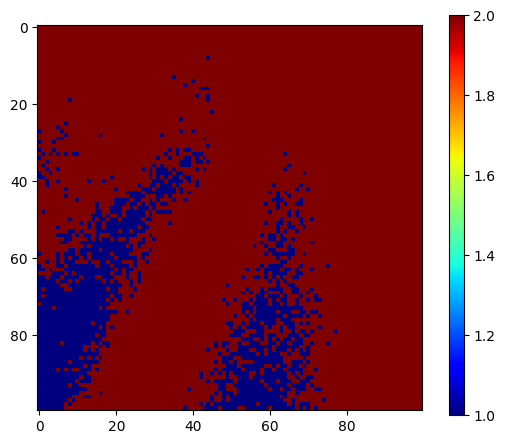

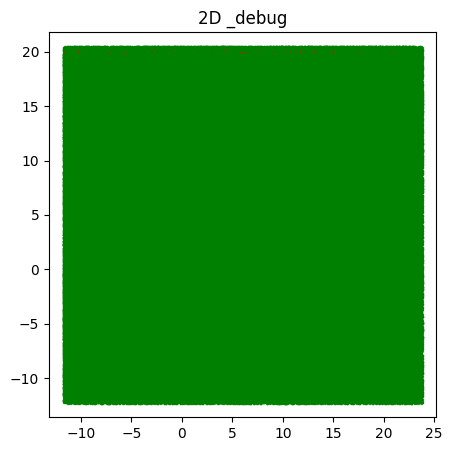

In [10]:
lid_finder = ID_finder_T()
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lid_finder.plot_LID(X_2d, DM=projecter, grid=100, mode='dim', ax=ax, sample_size=20)

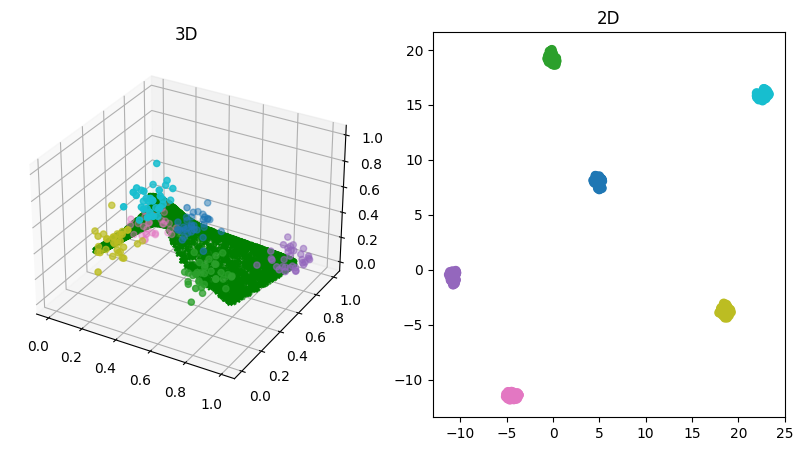

In [ ]:

fig0

In [ ]:
lid_finder.LID_map 

array([[1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2],
       [2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2],
       [2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
lid_finder.LID_eval.min() 

-8.353525e-10